# Email Spam Detection with Machine Learning

In [163]:
# Import Libraries
# Importing Numpy & Pandas for data processing & data wrangling
import numpy as np
import pandas as pd

# Importing  tools for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import evaluation metric libraries
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

# Word Cloud library
from wordcloud import WordCloud, STOPWORDS

# Library used for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import model selection libraries
from sklearn.model_selection import train_test_split

# Library used for ML Model implementation
from sklearn.naive_bayes import MultinomialNB

# Importing the Pipeline class from scikit-learn
from sklearn.pipeline import Pipeline

# Library used for ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [90]:

df = pd.read_csv("spam.csv", encoding='latin-1')
df = df[['v1', 'v2']]             # Keep only the needed columns
df.columns = ['label', 'message'] # Rename for clarity

print(df.head())


  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


# Dataset Rows & Columns count

In [91]:
# Dataset Rows & Columns count
# Checking number of rows and columns of the dataset using shape
print("Number of rows are: ",df.shape[0])
print("Number of columns are: ",df.shape[1])

Number of rows are:  5572
Number of columns are:  2


# Dataset Information

In [92]:
# Dataset Info
# Checking information about the dataset using info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


# Duplicate Values

In [93]:
# Dataset Duplicate Value Count
dup = df.duplicated().sum()
print(f'number of duplicated rows are {dup}')

number of duplicated rows are 403


# Missing Values/Null Values

In [94]:
# Missing Values/Null Values Count
df.isnull().sum()

label      0
message    0
dtype: int64

# Understanding The Variables

In [95]:
# Dataset Columns
df.columns
     

Index(['label', 'message'], dtype='object')

In [96]:
# Dataset Describe (all columns included)
df.describe(include= 'all').round(2)
     

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


# Check Unique Values for each variable.

In [97]:
# Check Unique Values for each variable using a for loop.
for i in df.columns.tolist():
  print("No. of unique values in",i,"is",df[i].nunique())
     

No. of unique values in label is 2
No. of unique values in message is 5169


# Data Wrangling

In [105]:
# Load the dataset
df = pd.read_csv("spam.csv", encoding='latin-1')

# Drop unnamed or extra columns if they exist
df.drop(columns=[col for col in ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'] if col in df.columns], inplace=True)

# Rename columns
df.rename(columns={"v1": "Category", "v2": "Message"}, inplace=True)

# Keep only the required columns
df = df[['Category', 'Message']]

# Encode the label
df['label_num'] = df['Category'].map({'ham': 0, 'spam': 1})

In [106]:
# Create a binary 'Spam' column: 1 for 'spam' and 0 for 'ham', based on the 'Category' column.
df['Spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)

In [107]:
# Updated new dataset
df.head()

,Category,Message,label_num,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0,0
1,ham,Ok lar... Joking wif u oni...,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,1
3,ham,U dun say so early hor... U c already then say...,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,0


#  Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables

# Chart - 1 : Distribution of Spam vs Ham

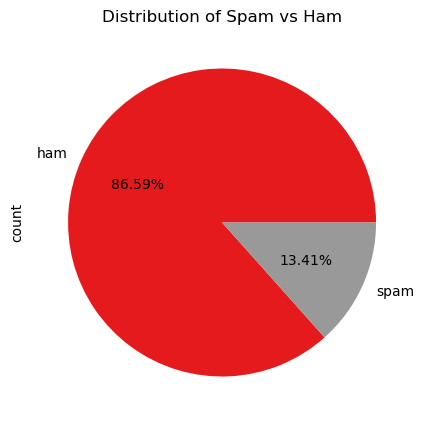

In [110]:
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline

# Calculate distribution
spread = df['Category'].value_counts()

# Set figure size
plt.rcParams['figure.figsize'] = (5, 5)

# Create pie chart
spread.plot(kind='pie', autopct='%1.2f%%', cmap='Set1')

# Set title
plt.title('Distribution of Spam vs Ham')

# Show the chart inline
plt.show()

     

# Chart - 2 : Most Used Words in Spam Messages

In [111]:
# Splitting Spam Messages
df_spam = df[df['Category']=='spam'].copy()

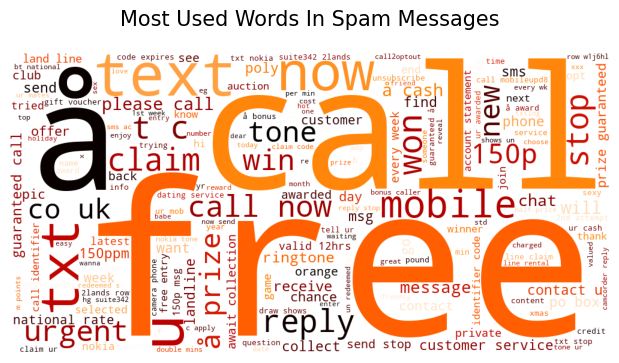

In [112]:
# Chart - 2 WordCloud Plot Visualization Code For Most Used Words in Spam Messages
# Create a String to Store All The Words
comment_words = ''

# Remove The Stopwords
stopwords = set(STOPWORDS)

# Iterate Through The Column
for val in df_spam.Message:

    # Typecaste Each Val to String
    val = str(val)

    # Split The Value
    tokens = val.split()

    # Converts Each Token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

# Set Parameters
wordcloud = WordCloud(width = 1000, height = 500,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10,
                max_words = 1000,
                colormap = 'gist_heat_r').generate(comment_words)

# Set Labels
plt.figure(figsize = (6,6), facecolor = None)
plt.title('Most Used Words In Spam Messages', fontsize = 15, pad=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# Display Chart
plt.show()
     


# Data Splitting


In [113]:
# Splitting the data to train and test
X_train,X_test,y_train,y_test=train_test_split(df.Message,df.Spam,test_size=0.25)

# ML Model Implementation

In [114]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    '''The function will take model, x train, x test, y train, y test
    and then it will fit the model, then make predictions on the trained model,
    it will then print roc-auc score of train and test, then plot the roc, auc curve,
    print confusion matrix for train and test, then print classification report for train and test,
    then plot the feature importances if the model has feature importances,
    and finally it will return the following scores as a list:
    recall_train, recall_test, acc_train, acc_test, roc_auc_train, roc_auc_test, F1_train, F1_test
    '''

    # fit the model on the training data
    model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    pred_prob_train = model.predict_proba(X_train)[:,1]
    pred_prob_test = model.predict_proba(X_test)[:,1]

    # calculate ROC AUC score
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    roc_auc_test = roc_auc_score(y_test, y_pred_test)
    print("\nTrain ROC AUC:", roc_auc_train)
    print("Test ROC AUC:", roc_auc_test)

    # plot the ROC curve
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_prob_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_prob_test)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr_train, tpr_train, label="Train ROC AUC: {:.2f}".format(roc_auc_train))
    plt.plot(fpr_test, tpr_test, label="Test ROC AUC: {:.2f}".format(roc_auc_test))
    plt.legend()
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # calculate confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    fig, ax = plt.subplots(1, 2, figsize=(11,4))

    print("\nConfusion Matrix:")
    sns.heatmap(cm_train, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[0])
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    ax[0].set_title("Train Confusion Matrix")

    sns.heatmap(cm_test, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[1])
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")
    ax[1].set_title("Test Confusion Matrix")

    plt.tight_layout()
    plt.show()


    # calculate classification report
    cr_train = classification_report(y_train, y_pred_train, output_dict=True)
    cr_test = classification_report(y_test, y_pred_test, output_dict=True)
    print("\nTrain Classification Report:")
    crt = pd.DataFrame(cr_train).T
    print(crt.to_markdown())
    # sns.heatmap(pd.DataFrame(cr_train).T.iloc[:, :-1], annot=True, cmap="Blues")
    print("\nTest Classification Report:")
    crt2 = pd.DataFrame(cr_test).T
    print(crt2.to_markdown())
    # sns.heatmap(pd.DataFrame(cr_test).T.iloc[:, :-1], annot=True, cmap="Blues")


    precision_train = cr_train['weighted avg']['precision']
    precision_test = cr_test['weighted avg']['precision']

    recall_train = cr_train['weighted avg']['recall']
    recall_test = cr_test['weighted avg']['recall']

    acc_train = accuracy_score(y_true = y_train, y_pred = y_pred_train)
    acc_test = accuracy_score(y_true = y_test, y_pred = y_pred_test)

    F1_train = cr_train['weighted avg']['f1-score']
    F1_test = cr_test['weighted avg']['f1-score']

    model_score = [precision_train, precision_test, recall_train, recall_test, acc_train, acc_test, roc_auc_train, roc_auc_test, F1_train, F1_test ]
    return model_score

# ML Model: Multinomial Naive Bayes


In [115]:
# ML Model - 1 Implementation
# Create a machine learning pipeline using scikit-learn, combining text vectorization (CountVectorizer)
# and a Multinomial Naive Bayes classifier for email spam detection.
clf = Pipeline([
    ('vectorizer', CountVectorizer()),  # Step 1: Text data transformation
    ('nb', MultinomialNB())  # Step 2: Classification using Naive Bayes
])

# Model is trained (fit) and predicted in the evaluate model
     


Train ROC AUC: 0.9825489370246484
Test ROC AUC: 0.9712888267801564


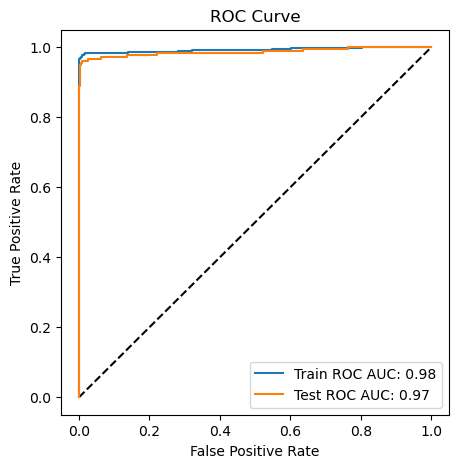


Confusion Matrix:


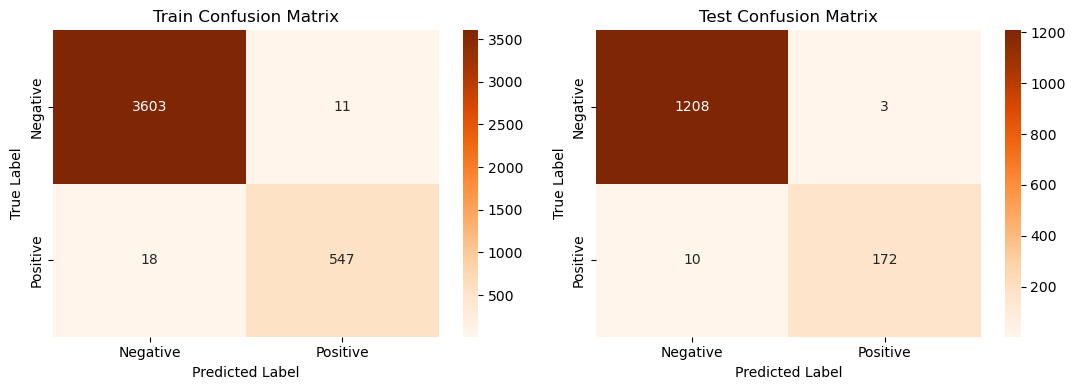


Train Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.995029 | 0.996956 |   0.995992 | 3614        |
| 1            |    0.980287 | 0.968142 |   0.974176 |  565        |
| accuracy     |    0.993061 | 0.993061 |   0.993061 |    0.993061 |
| macro avg    |    0.987658 | 0.982549 |   0.985084 | 4179        |
| weighted avg |    0.993036 | 0.993061 |   0.993042 | 4179        |

Test Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.99179  | 0.997523 |   0.994648 | 1211        |
| 1            |    0.982857 | 0.945055 |   0.963585 |  182        |
| accuracy     |    0.990668 | 0.990668 |   0.990668 |    0.990668 |
| macro avg    |    0.987323 | 0.971289 |   0.979117 | 1393        |
| weighted avg |    0.990623 | 0.990668 |   

In [116]:
# Visualizing evaluation Metric Score chart
MultinomialNB_score = evaluate_model(clf, X_train, X_test, y_train, y_test)

In [150]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable


In [151]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Define base classifiers with pipelines
nb_clf = make_pipeline(TfidfVectorizer(), MultinomialNB())
lr_clf = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))
rf_clf = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
xgb_clf = make_pipeline(TfidfVectorizer(), XGBClassifier(use_label_encoder=False, eval_metric='logloss'))

# Voting classifier with pipelines
ensemble_clf = VotingClassifier(
    estimators=[
        ('nb', nb_clf),
        ('lr', lr_clf),
        ('rf', rf_clf),
        ('xgb', xgb_clf)
    ],
    voting='soft'
)

# Fit on raw text X_train (not vectorized)
ensemble_clf.fit(X_train, y_train)

# Predict
ensemble_preds = ensemble_clf.predict(X_test)


In [152]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

print("Classification Report:\n", classification_report(y_test, ensemble_preds))

cm = confusion_matrix(y_test, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ensemble_clf.classes_)
disp.plot(cmap='Blues')

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1211
           1       1.00      0.85      0.92       182

    accuracy                           0.98      1393
   macro avg       0.99      0.93      0.95      1393
weighted avg       0.98      0.98      0.98      1393



In [153]:
%%capture
!pip install shap


In [154]:
# Assume ensemble_clf is your VotingClassifier
for name, model in ensemble_clf.named_estimators_.items():
    print(f"{name}: {type(model)}")



nb: <class 'sklearn.pipeline.Pipeline'>
lr: <class 'sklearn.pipeline.Pipeline'>
rf: <class 'sklearn.pipeline.Pipeline'>
xgb: <class 'sklearn.pipeline.Pipeline'>


In [155]:
tree_model = ensemble_clf.named_estimators_['rf']  # or whatever actual key name appears


In [156]:
print(ensemble_clf.named_estimators_)



{'nb': Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())]), 'lr': Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression(max_iter=1000))]), 'rf': Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier', RandomForestClassifier())]), 'xgb': Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                 

In [157]:
import joblib
joblib.dump(ensemble_clf, "spam_ensemble_model.pkl")
print("Model saved as spam_ensemble_model.pkl")


Model saved as spam_ensemble_model.pkl


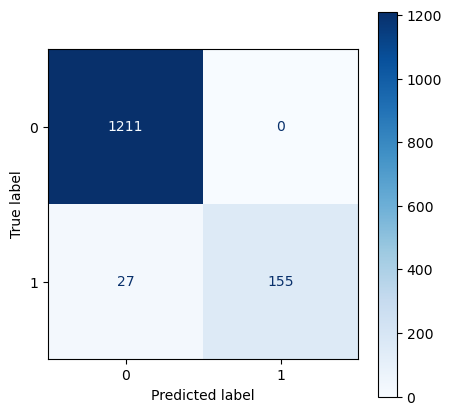

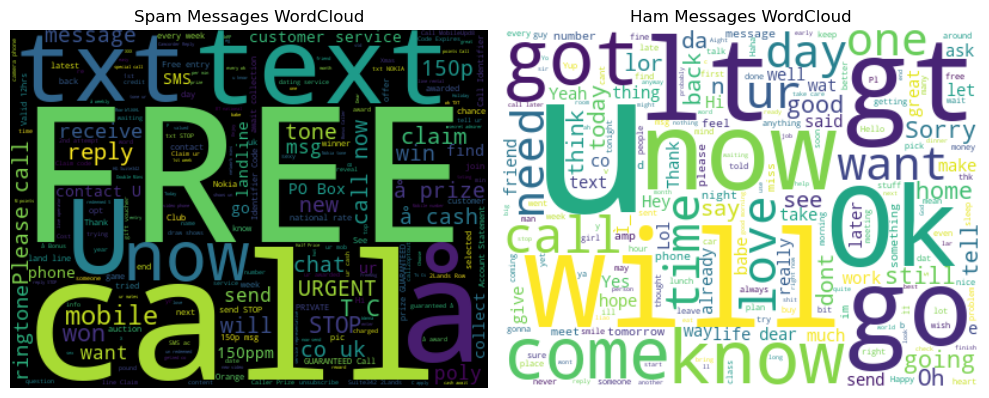

In [158]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

spam_words = ' '.join(df[df['Category'] == 'spam']['Message'])
ham_words = ' '.join(df[df['Category'] == 'ham']['Message'])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Spam Messages WordCloud")
wordcloud_spam = WordCloud(width=400, height=300, background_color='black').generate(spam_words)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Ham Messages WordCloud")
wordcloud_ham = WordCloud(width=400, height=300, background_color='white').generate(ham_words)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis('off')

plt.tight_layout()
plt.show()

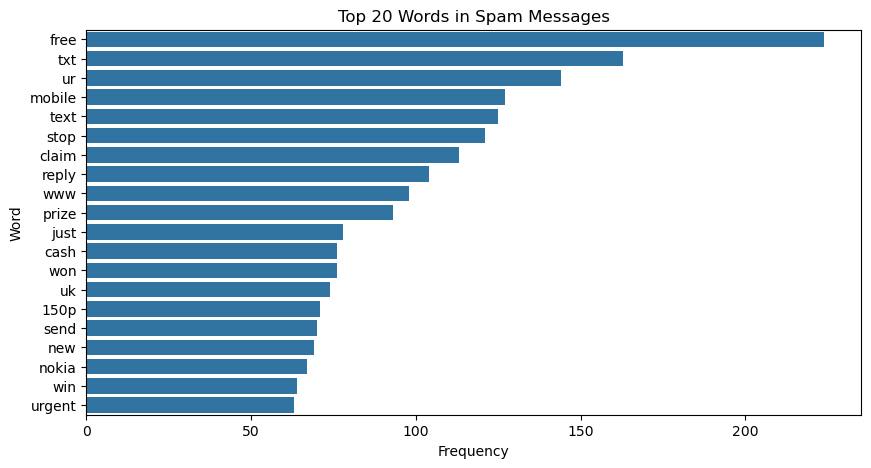

In [159]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import seaborn as sns

cv = CountVectorizer(stop_words='english')
spam_cv = cv.fit_transform(df[df['Category'] == 'spam']['Message'])

sum_words = spam_cv.sum(axis=0)
word_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)[:20]

words_df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])

plt.figure(figsize=(10,5))
sns.barplot(x='Frequency', y='Word', data=words_df)
plt.title("Top 20 Words in Spam Messages")
plt.show()

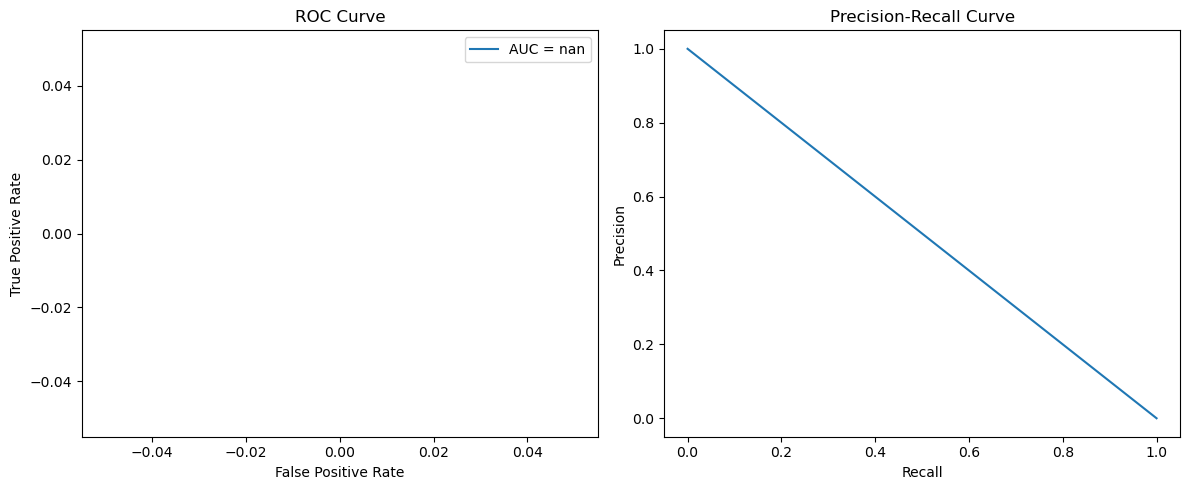

In [160]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# For binary labels
y_proba = ensemble_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label='spam')
precision, recall, _ = precision_recall_curve(y_test, y_proba, pos_label='spam')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

plt.tight_layout()
plt.show()


# Email Spam Detection System


In [161]:
# Defining a function for the Email Spam Detection System
def detect_spam(email_text):
    # Load the trained classifier (clf) here
    # Replace the comment with your code to load the classifier model

    # Make a prediction using the loaded classifier
    prediction = clf.predict([email_text])

    if prediction == 0:
        return "This is a Ham Email!"
    else:
        return "This is a Spam Email!"

     

In [162]:
# Example of how to use the function
sample_email = 'Free Tickets for IPL'
result = detect_spam(sample_email)
print(result)
     

This is a Spam Email!
